### Proyecto práctico

Consideraciones a tener en cuenta:

- El entorno sobre el que trabajaremos será _SpaceInvaders-v0_ y el algoritmo que usaremos será _DQN_.

- Para nuestro ejercicio, una solución óptima será alcanzada cuando el agente consiga una **media de recompensa por encima de 20 puntos en modo test**. Por ello, esta media de la recompensa se calculará a partir del código de test en la última celda del notebook.

Este proyecto práctico consta de tres partes:

   1) Implementar la red neuronal que se usará en la solución
    
   2) Implementar las distintas piezas de la solución DQN
    
   3) Justificar la respuesta en relación a los resultados obtenidos

IMPORTANTE:

- Si no se consigue una puntuación óptima, responder sobre la mejor puntuación obtenida.

- Para entrenamientos largos, recordad que podéis usar checkpoints de vuestros modelos para retomar los entrenamientos. En este caso, recordad cambiar los parámetros adecuadamente (sobre todo los relacionados con el proceso de exploración).

- Tened en cuenta que las versiones de librerías recomendadas son Tensorflow==1.13.1, Keras==2.2.4 y keras-rl==0.4.2

#### Preparar entorno sobre TF2

In [ ]:
# Conectamos con nuestro Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Establezco una ruta absoluta a un directorio existente de mi Google Drive (cambiar a drive propio)
BASE_FOLDER = "/content/drive/Othercomputers/My MacBook Pro/08_aprendizaje_por_refuerzo/proyecto/"

Mounted at /content/drive


In [ ]:
# install keras-rl2 that works with tensorflow 2.x
!pip install keras-rl2 > /dev/null 2>&1

# install gym and atari ROMs
!pip install -U gym>=0.21.0
!pip install -U gym[atari,accept-rom-license]

     |████████████████████████████████| 1.6 MB 8.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.4.2-py3-none-any.whl size=441026 sha256=e32ebbbd8f8a25b9259d80cbe4e85dbb2cdaf5f7f0228e2f487c8566580695fb
  Stored in directory: /root/.cache/pip/wheels/87/67/2e/6147e7912fe37f5408b80d07527dab807c1d25f5c403a9538a
Successfully built AutoROM.accept-rom-license


In [ ]:
# install the relevant libraries to make rendering possible
!pip install pyvirtualdisplay > /dev/null 2>&1
!apt-get update
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [ ]:
# import the relevant libraries 
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import math
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay


/usr/local/lib/python3.7/dist-packages/ale_py/roms/utils.py:90: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for external in metadata.entry_points().get(self.group, []):


In [ ]:

"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

#### Importar librerías

In [ ]:
from __future__ import division

from PIL import Image
import numpy as np
import gym

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Convolution2D, Permute, Dropout, BatchNormalization
#from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam
import keras.backend as K

from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.core import Processor
from rl.callbacks import FileLogger, ModelIntervalCheckpoint

#### Configuración base

In [ ]:
INPUT_SHAPE = (84, 84)
WINDOW_LENGTH = 4

env_name = 'SpaceInvaders-v0'
#env = wrap_env(gym.make(env_name))
env = gym.make(env_name)

np.random.seed(123)
env.seed(123)
nb_actions = env.action_space.n

In [ ]:
class AtariProcessor(Processor):
    def process_observation(self, observation):
        assert observation.ndim == 3  # (height, width, channel)
        img = Image.fromarray(observation)
        img = img.resize(INPUT_SHAPE).convert('L') # a escala de grises
        processed_observation = np.array(img)
        assert processed_observation.shape == INPUT_SHAPE
        return processed_observation.astype('uint8') # casting a 8 bits

    def process_state_batch(self, batch):
        processed_batch = batch.astype('float32') / 255. # normalizar entre 0 y 1
        return processed_batch

    def process_reward(self, reward):
        return np.clip(reward, -1., 1.) # se acota para que no sea tan sensible a valores extremos

In [ ]:
# Acciones disponibles en el entorno
nb_actions = env.action_space.n
nb_actions

6

In [ ]:
# Nombres de las acciones
env.unwrapped.get_action_meanings()

['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

In [ ]:
# Dimensions de las observaciones del entorno
env.observation_space.shape

(210, 160, 3)

1) Implementación de la red neuronal

In [ ]:
# Next, we build our model. We use the same model that was described by Mnih et al. (2015).
input_shape = (WINDOW_LENGTH,) + INPUT_SHAPE
model = Sequential()

# segun el backend, se usa un ordenamiento de dimensiones diferente (para tensorflow o theano)
#if K.image_dim_ordering() == 'tf':
if K.image_data_format() == 'channels_last':
    # (width, height, channels)
    model.add(Permute((2, 3, 1), input_shape=input_shape))
#elif K.image_dim_ordering() == 'th':
elif image_data_format() == 'channels_first':
    # (channels, width, height)
    model.add(Permute((1, 2, 3), input_shape=input_shape))
else:
    raise RuntimeError('Unknown image_dim_ordering.')
# conv_1
model.add(Convolution2D(32, (8, 8), strides=(4, 4), padding = 'SAME'))
model.add(Activation('relu'))
# conv_2
model.add(Convolution2D(64, (4, 4), strides=(2, 2), padding = 'SAME'))
model.add(Activation('relu'))
# conv_3
model.add(Convolution2D(64, (3, 3), strides=(1, 1), padding = 'SAME'))
model.add(Activation('relu'))
# FC
model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(nb_actions))
model.add(Activation('linear')) # lineal porque son las recompensas esperadas a futuro para cada accion (nb_actions)
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 permute (Permute)           (None, 84, 84, 4)         0         
                                                                 
 conv2d (Conv2D)             (None, 21, 21, 32)        8224      
                                                                 
 activation (Activation)     (None, 21, 21, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        32832     
                                                                 
 activation_1 (Activation)   (None, 11, 11, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 11, 11, 64)        36928     
                                                                 
 activation_2 (Activation)   (None, 11, 11, 64)        0

2) Implementación de la solución DQN

In [ ]:
memory = SequentialMemory(limit=1000000, window_length=WINDOW_LENGTH)
processor = AtariProcessor()

In [ ]:
# nb_steps será el tiempo que durará la exploración, antes de pasar a explotación. 
# value_test guarda un pelín de aleatoriedad para minimizar el riesgo de estancamiento en minimos durante el test
# empieza muy aleatorio a 1 (100%) de acciones aleatorias y va decreciendo a más acciones 'predichas/aprendidas'
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps',
                              value_max=1., value_min=.1, value_test=.05,
                              nb_steps=1000000)

In [ ]:
# recordar que el modelo se 'duplica' uno para target y otro para predicción, ambos idénticos
# gamma es el discount factor de las rewards
# target se actualiza cada 10000 steps
# cada 20 steps, se actualizan los pesos del modelo
# bajamos el learning rate
dqn = DQNAgent(model=model, nb_actions=nb_actions, policy=policy,
               memory=memory, processor=processor,
               nb_steps_warmup=50000, gamma=.99,
               target_model_update=10000,
               train_interval=20)
dqn.compile(Adam(learning_rate=.00025), metrics=['mae'])

In [ ]:
# Training part
# log en pantalla cada 10,000 steps
# cada 250000 steps almaceno versiones del modelo (callbacks)
# el log escrito, cada 100 steps
weights_filename = BASE_FOLDER+'dqn7_{}_weights.h5f'.format(env_name)
checkpoint_weights_filename = BASE_FOLDER+'dqn7_' + env_name + '_weights_{step}.h5f'
log_filename = BASE_FOLDER+'dqn7_{}_log.json'.format(env_name)
callbacks = [ModelIntervalCheckpoint(checkpoint_weights_filename, interval=500000)]
callbacks += [FileLogger(log_filename, interval=100)]

dqn.fit(env, callbacks=callbacks, nb_steps=2000000, log_interval=10000, visualize=False)

dqn.save_weights(weights_filename, overwrite=True)

Training for 2000000 steps ...
Interval 1 (0 steps performed)


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


10000/10000 [==============================] - 46s 4ms/step - reward: 0.0117
14 episodes - episode_reward: 8.000 [1.000, 16.000] - lives: 2.163

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 36s 4ms/step - reward: 0.0138
14 episodes - episode_reward: 9.929 [5.000, 20.000] - lives: 2.148

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 37s 4ms/step - reward: 0.0126
13 episodes - episode_reward: 9.692 [4.000, 23.000] - lives: 2.095

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 36s 4ms/step - reward: 0.0144
13 episodes - episode_reward: 11.308 [4.000, 23.000] - lives: 1.940

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 37s 4ms/step - reward: 0.0141
13 episodes - episode_reward: 10.692 [2.000, 22.000] - lives: 2.163

Interval 6 (50000 steps performed)
10000/10000 [==============================] - 73s 7ms/step - reward: 0.0118
16 episodes - episode

In [ ]:
# use PyvirtualDisplay to create a “virtual display” that we will send our rendered frames to
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()


In [ ]:
# wrap a Monitor around environment
env_monitor = wrap_env(env)

In [ ]:
# Testing part to calculate the mean reward
weights_filename = BASE_FOLDER+'dqn7_{}_weights.h5f'.format(env_name)
dqn.load_weights(weights_filename)
dqn.test(env_monitor, nb_episodes=10, visualize=True)
show_video()

Testing for 10 episodes ...
Episode 1: reward: 14.000, steps: 628
Episode 2: reward: 25.000, steps: 1031
Episode 3: reward: 27.000, steps: 1073
Episode 4: reward: 23.000, steps: 942
Episode 5: reward: 14.000, steps: 553
Episode 6: reward: 21.000, steps: 841
Episode 7: reward: 31.000, steps: 1580
Episode 8: reward: 27.000, steps: 1172
Episode 9: reward: 21.000, steps: 971
Episode 10: reward: 30.000, steps: 1038


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

json_filename = BASE_FOLDER+'dqn7_SpaceInvaders-v0_log.json'
df = pd.read_json(json_filename)
df.head()

,loss,mae,mean_q,mean_eps,episode_reward,nb_episode_steps,nb_steps,episode,duration
0,NaN,NaN,NaN,NaN,6,414,414,0,9.032557
1,NaN,NaN,NaN,NaN,7,561,975,1,2.016543
2,NaN,NaN,NaN,NaN,16,977,1952,2,3.675545
3,NaN,NaN,NaN,NaN,1,520,2472,3,1.831401
4,NaN,NaN,NaN,NaN,7,630,3102,4,2.208207


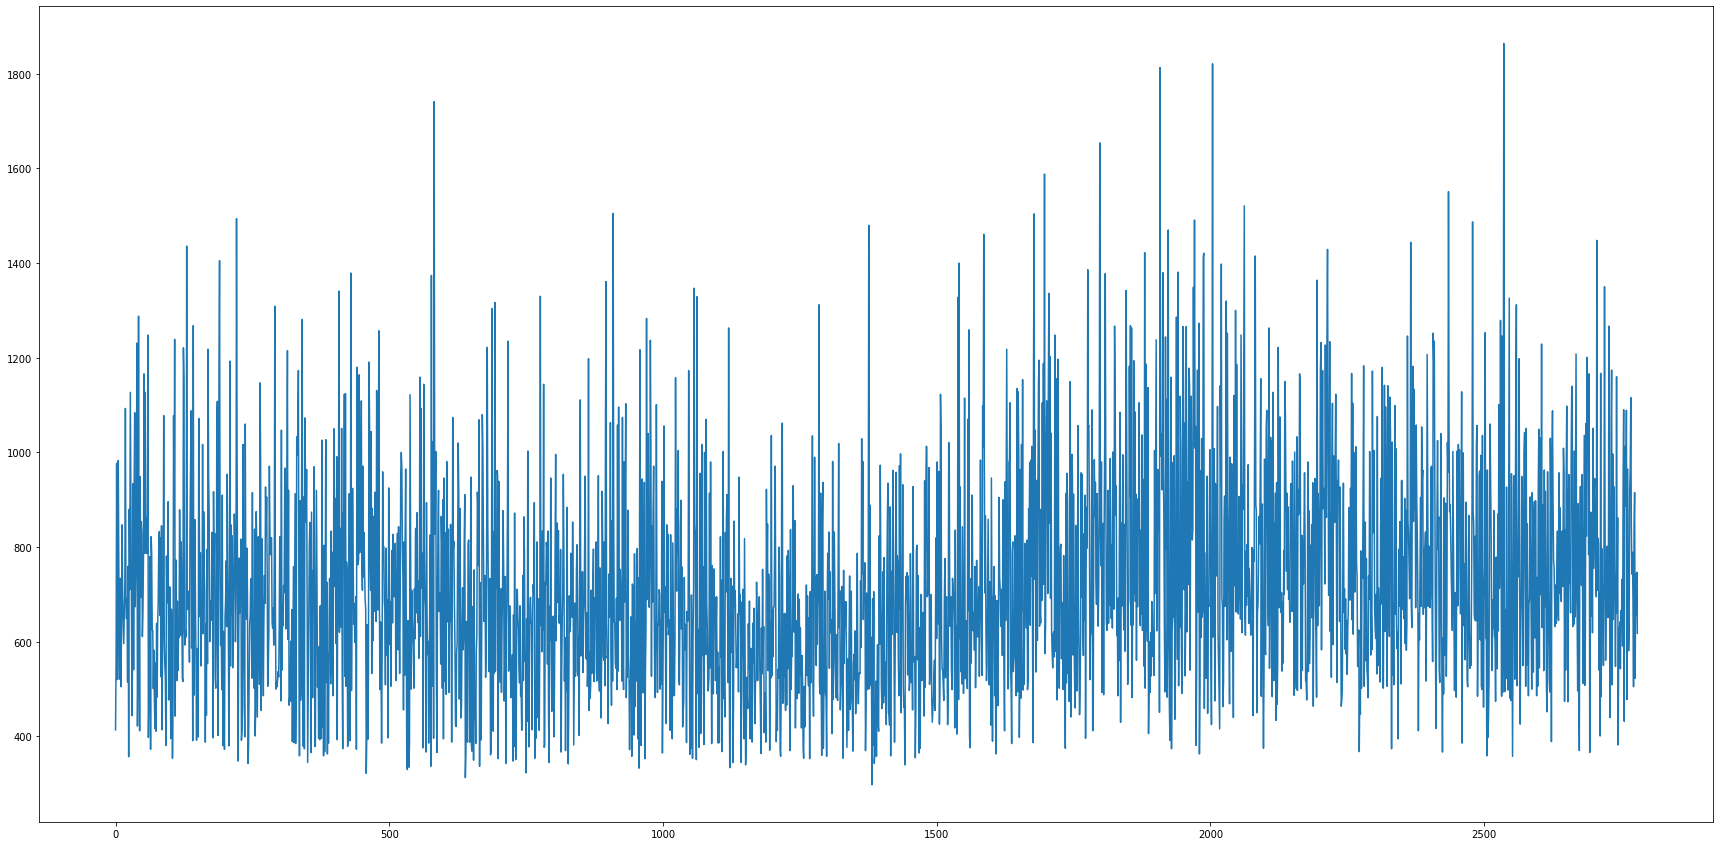

In [ ]:
plt.figure(figsize=(30, 15))
df["nb_episode_steps"].astype(int).plot()

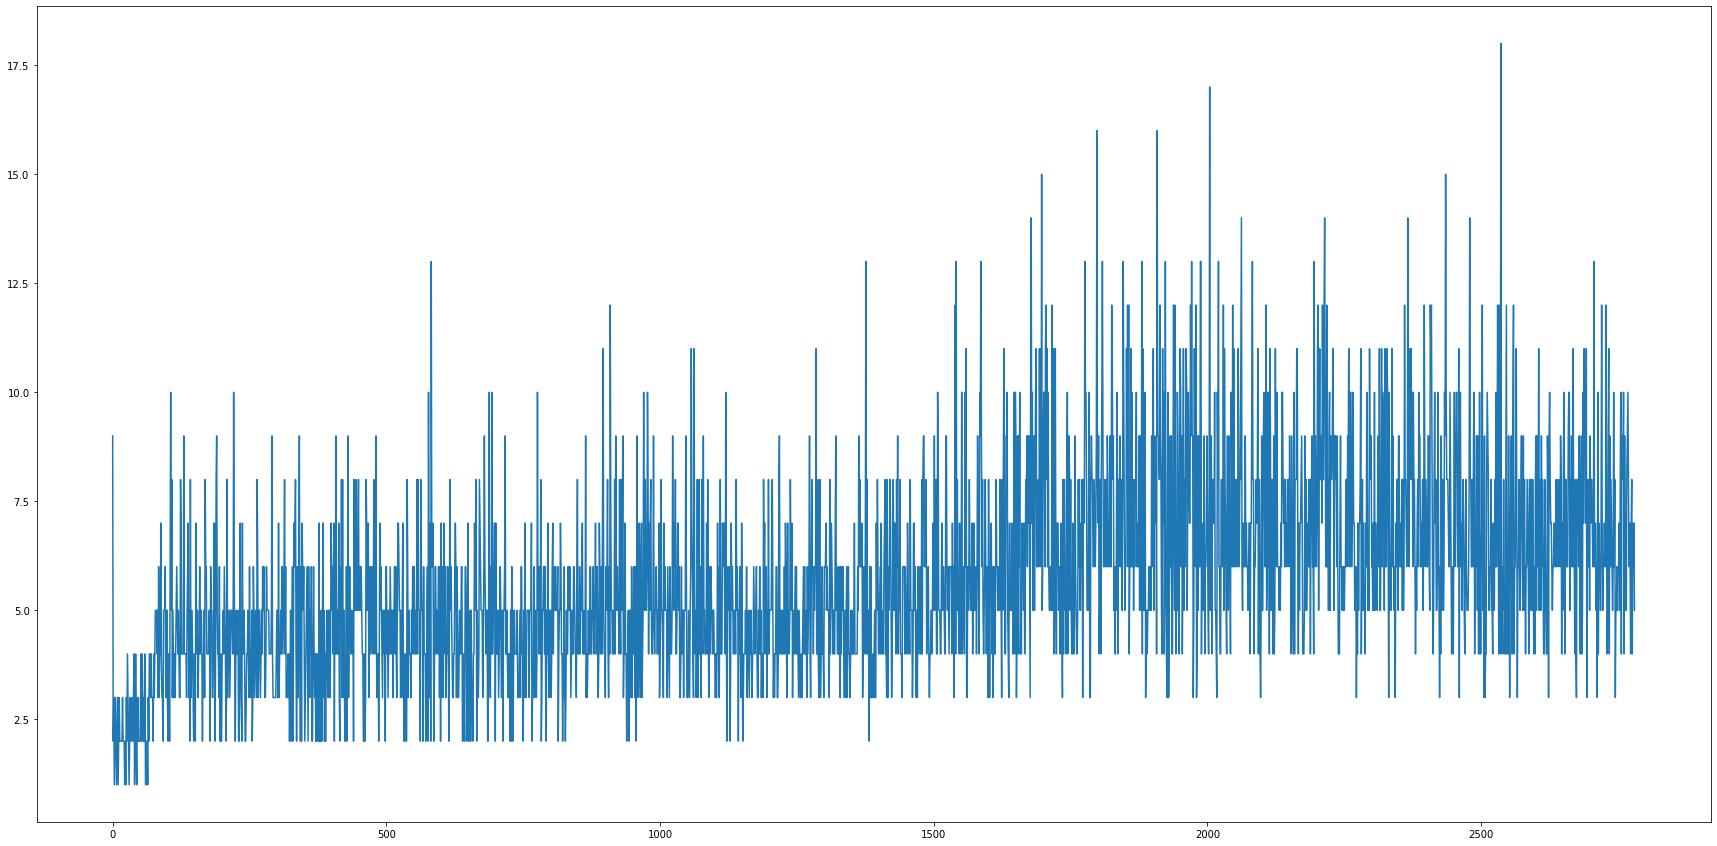

In [ ]:
plt.figure(figsize=(30, 15))
df["duration"].astype(int).plot()

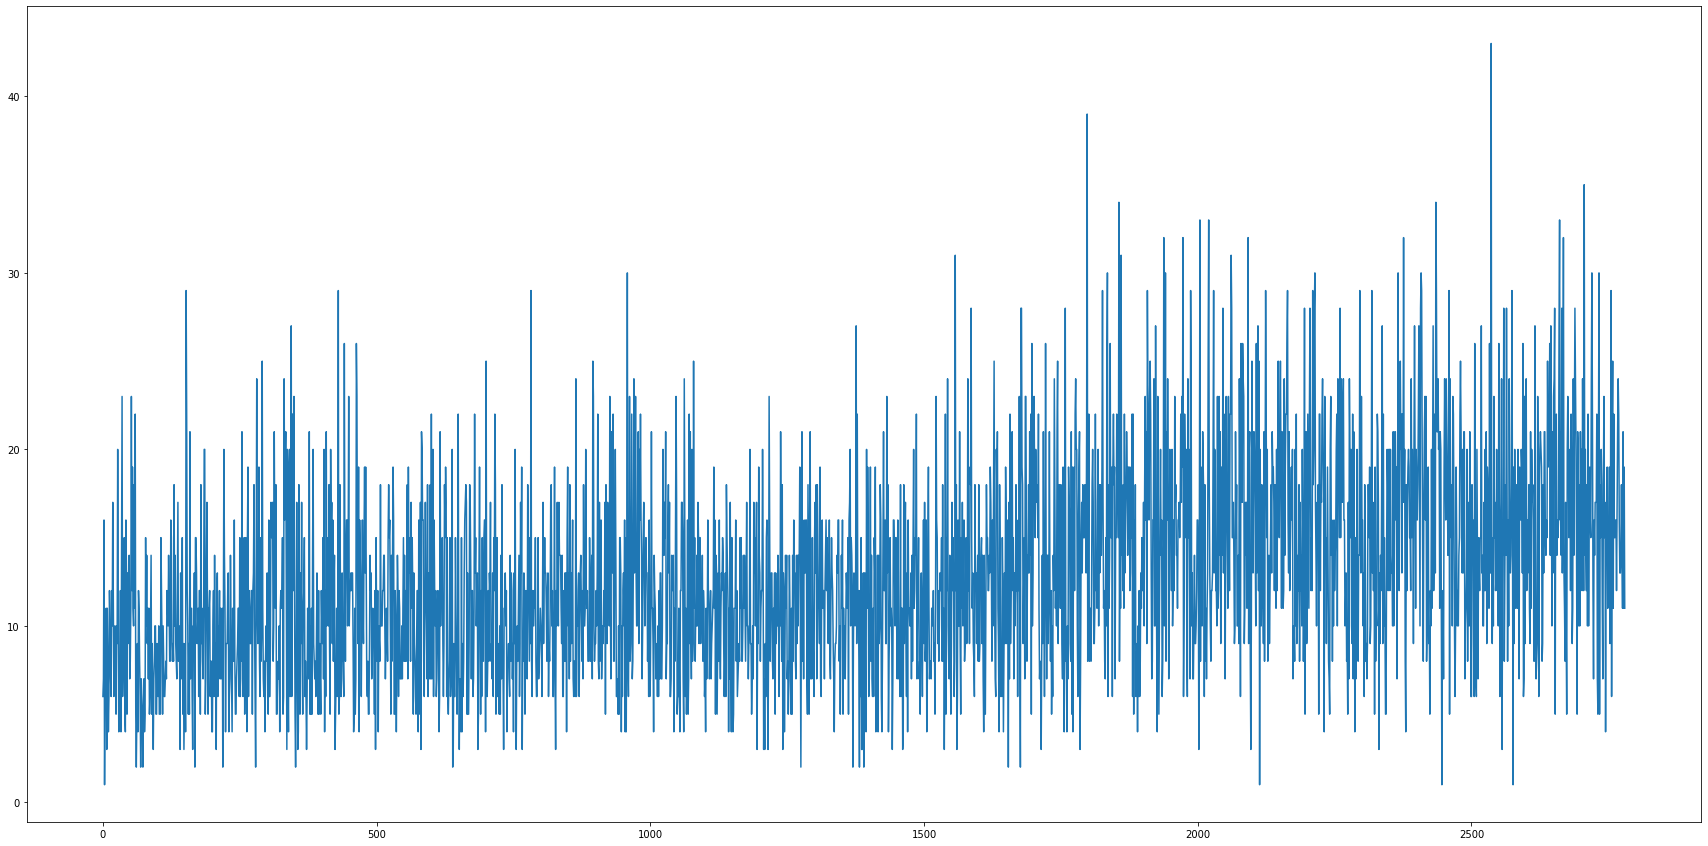

In [ ]:
plt.figure(figsize=(30, 15))
df["episode_reward"].astype(int).plot()

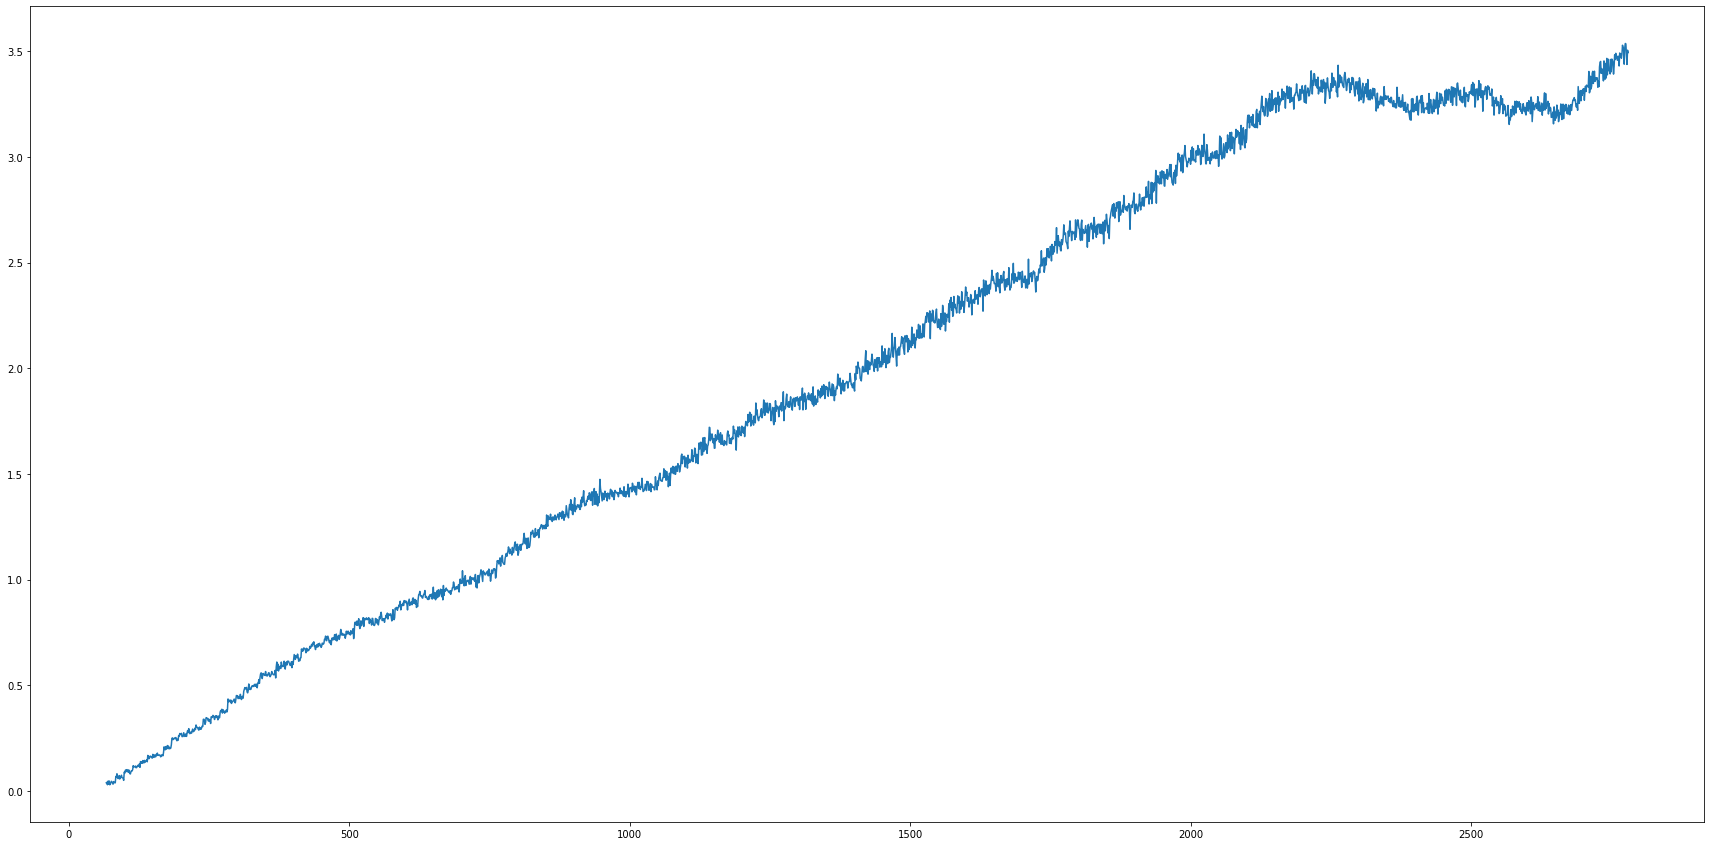

In [ ]:
plt.figure(figsize=(30, 15))
df["mean_q"].plot()

3) Justificación de los parámetros seleccionados y de los resultados obtenidos